# MODEL SETUP

In [1]:
import os
import sys
import json
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import skimage.draw
import tensorflow as tf

# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library

from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

#Import adaptionsf
from fashion_config import FashionConfig
from fashion_dataset import FashionDataset

%matplotlib inline

# Hide some tensorflaw warning messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

/home/vic/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/vic/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/vic/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/vic/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarnin

In [2]:
""" Load config """ 
config = FashionConfig()
#config.display()

In [3]:
""" Prepare dataset """ 
dataset_train = FashionDataset()
dataset_train.load_fashion(ROOT_DIR + '/datasets/big_deepfashion2', "train")
dataset_train.prepare()

dataset_val = FashionDataset()
dataset_val.load_fashion(ROOT_DIR + '/datasets/big_deepfashion2', "val")
dataset_val.prepare()

In [4]:
class InferenceConfig(FashionConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)







Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


In [9]:
# Load trained weights
model_path = "../logs/final_logs/logs_mask_rcnn_fashion_0050.h5"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  ../logs/final_logs/logs_mask_rcnn_fashion_0050.h5


# TEST IMAGES

In [6]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

original_image           shape: (640, 640, 3)         min:    0.00000  max:  255.00000  uint8
image_meta               shape: (26,)                 min:    0.00000  max: 182882.00000  float64
gt_class_id              shape: (2,)                  min:    1.00000  max:    9.00000  uint8
gt_bbox                  shape: (2, 4)                min:  234.00000  max:  422.00000  int32
gt_mask                  shape: (640, 640, 2)         min:    0.00000  max:    1.00000  uint8
gt_landmark              shape: (640, 640, 2)         min:    0.00000  max:    2.00000  float64


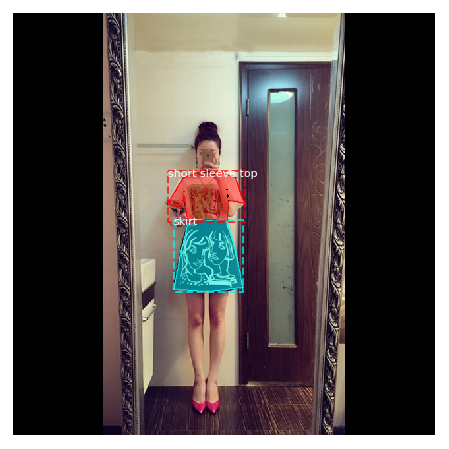

Processing 1 images
image                    shape: (640, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 640, 640, 3)      min: -123.70000  max:  148.10000  float64
image_metas              shape: (1, 26)               min:    0.00000  max:  640.00000  int64
anchors                  shape: (1, 102300, 4)        min:   -0.56657  max:    1.46641  float32


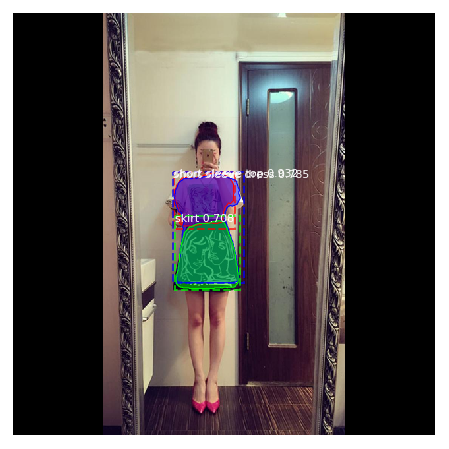

In [10]:
# Test on a random image
image_id = random.choice(dataset_train.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask, gt_landmark =\
    modellib.load_image_gt(dataset_train, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)
log("gt_landmark", gt_landmark)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_landmark, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

results = model.detect([original_image], verbose=2)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['landmarks'], r['class_ids'], 
                            dataset_train.class_names, r['scores'], ax=get_ax())

# CALCULATE MASK-AP

In [11]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_train.image_ids, 10)
APs = []
for image_id in image_ids:
    #Load image and ground truth data
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask, gt_landmark =\
    modellib.load_image_gt(dataset_train, inference_config, 
                           image_id, use_mini_mask=False)

    molded_images = np.expand_dims(modellib.mold_image(original_image, inference_config), 0)
    # Run object detection
    results = model.detect([original_image], verbose=1)
    r = results[0]
    
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

Processing 1 images
image                    shape: (640, 640, 3)         min:    0.00000  max:  230.00000  uint8
molded_images            shape: (1, 640, 640, 3)      min: -123.70000  max:  113.20000  float64
image_metas              shape: (1, 26)               min:    0.00000  max:  640.00000  int64
anchors                  shape: (1, 102300, 4)        min:   -0.56657  max:    1.46641  float32
Processing 1 images
image                    shape: (640, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 640, 640, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 26)               min:    0.00000  max:  640.00000  int64
anchors                  shape: (1, 102300, 4)        min:   -0.56657  max:    1.46641  float32
Processing 1 images
image                    shape: (640, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 640, 640, 3)      min: -123.70000  max:  151.10000